# Comparison of various regression algorithms on a simple 1D problem

Several regression algorithms implemented in Scikit-Learn are compared. The algorithms considered here are

- linear models with polynomal features
- Support Vector Machines (SVM)
- Gaussian Processes (GP)
- K Nearest Neighbors (KNN)
- multilayer preceptrons (MLP)

## Dependencies

Notebooks (links work only if the Docker container is running)

- [process_logs.ipynb](http://127.0.0.1:8888/notebooks/process_logs.ipynb)
- [process_plic_data.ipynb](http://127.0.0.1:8888/notebooks/process_plic_data.ipynb)

## Loading the data

The problem considered here is the approximation of $r(\varphi)$ for a spherical cap bubble, see the notebook *basilisk_2D_shape_approximation_simple.ipynb* for more information.

In [3]:
import helper_module as hm
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

%matplotlib inline

data_path = "../data/"
case = "bhaga_03_l16"
time = 30
output_path = "../output"
!mkdir -p ../output/

In [5]:
log_path = data_path + case + "/log." + case + ".csv"
log = hm.Logfile(log_path)
log.read_logfile(usecols=['time', 'x'])
row = log.find_closest("time", time)
plic_path = data_path + case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
facet = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)

Successfully read file ../data/bhaga_03_l16/log.bhaga_03_l16.csv
Successfully read file ../data/bhaga_03_l16/plic_clean/plic_089590.pkl


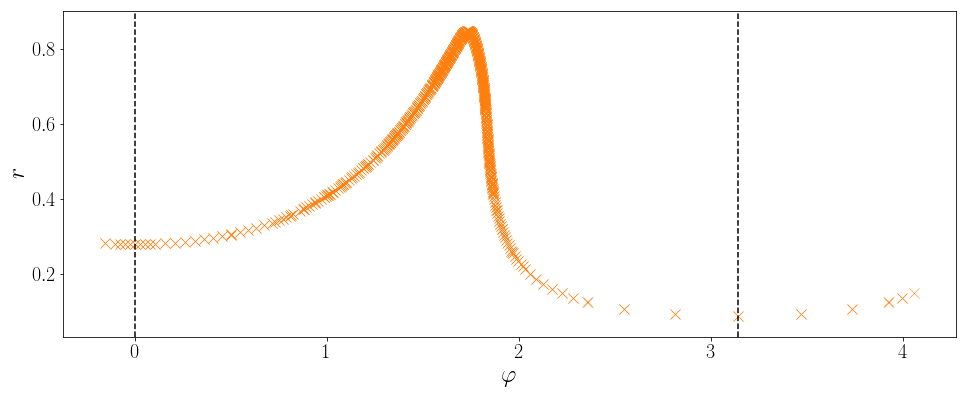

In [141]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

Np = 10 # reflect ten points at both poles

rad, phi = facet.get_facets(polar=True)
phi_order = np.argsort(phi)
phi_sorted = phi[phi_order]
rad_sorted = rad[phi_order]
phi_ext = np.concatenate((-phi_sorted[:Np+1], phi_sorted, 2*np.pi - phi_sorted[-Np:]), axis=0)
rad_ext = np.concatenate((rad_sorted[:Np+1], rad_sorted, rad_sorted[-Np:]), axis=0)
ax.scatter(phi_ext, rad_ext, marker="x", color="C1", s=100, lw=0.5)
ax.axvline(0.0, ls="--", color="k")
ax.axvline(np.pi, ls="--", color="k")

ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$r$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)

## Polynomial regression

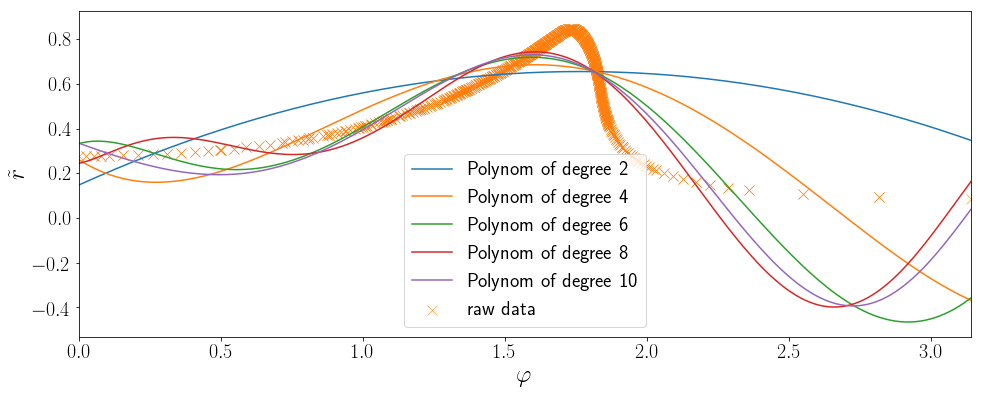

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

phi_eval = np.linspace(0.0, np.pi, 200)
ax.scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5, label="raw data")

for deg in range(2, 11, 2):
    model = Pipeline([('poly', PolynomialFeatures(degree=deg)), ('linear', LinearRegression(fit_intercept=False))])
    model.fit(phi_ext[:, np.newaxis], rad_ext)
    rad_model = model.predict(phi_eval[:, np.newaxis])
    ax.plot(phi_eval, rad_model, label="Polynom of degree {:1d}".format(deg))
    
ax.set_xlim(0.0, np.pi)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

## Support Vector Machine

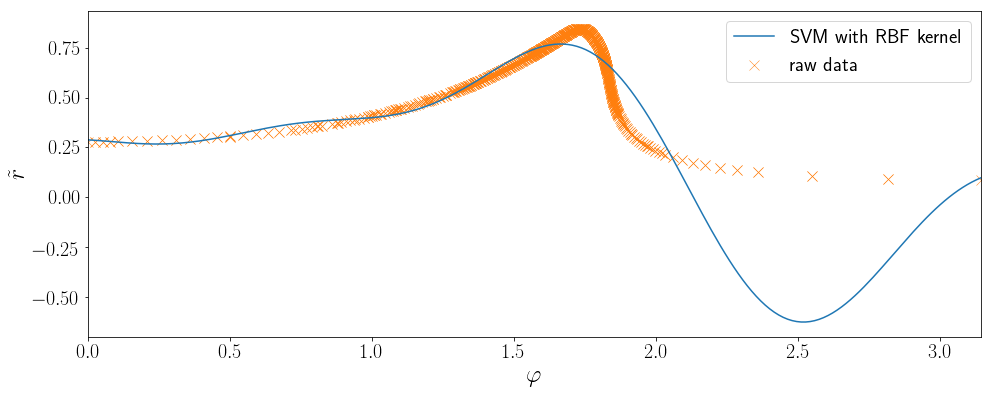

In [40]:
from sklearn.svm import SVR

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5, label="raw data")

svr_rbf = SVR(kernel='rbf', C=10, gamma="auto", epsilon=0.01)
res = svr_rbf.fit(phi_ext[:, np.newaxis], rad_ext).predict(phi_eval[:, np.newaxis])
ax.plot(phi_eval, res, label="SVM with RBF kernel")

ax.set_xlim(0.0, np.pi)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

## Gaussian processes

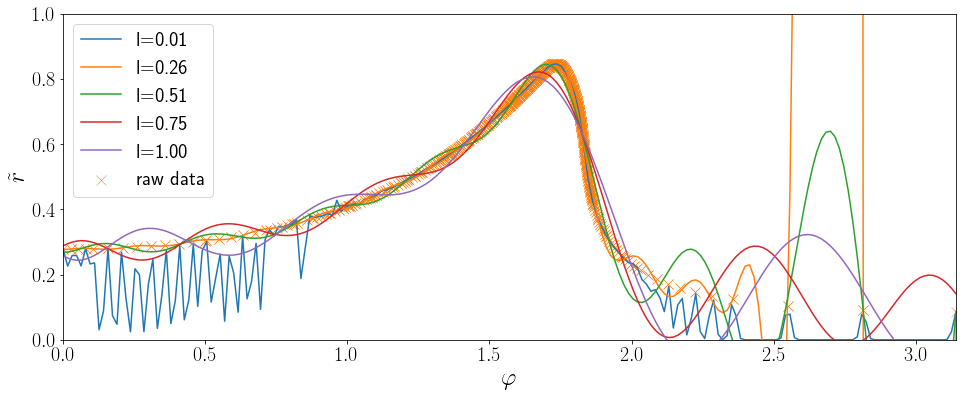

In [83]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5, label="raw data")

for l in np.linspace(0.01, 1.0, 5):
    kernel = RBF(1, (l, 100))
    # kernel = C() + Matern(length_scale=l, nu=3/2)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(phi_ext[:, np.newaxis], rad_ext)
    rad_model = gp.predict(phi_eval[:, np.newaxis], return_std=False)
    ax.plot(phi_eval, rad_model, label="l={:1.2f}".format(l))
    
ax.set_xlim(0.0, np.pi)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

## K Nearest Neighbors

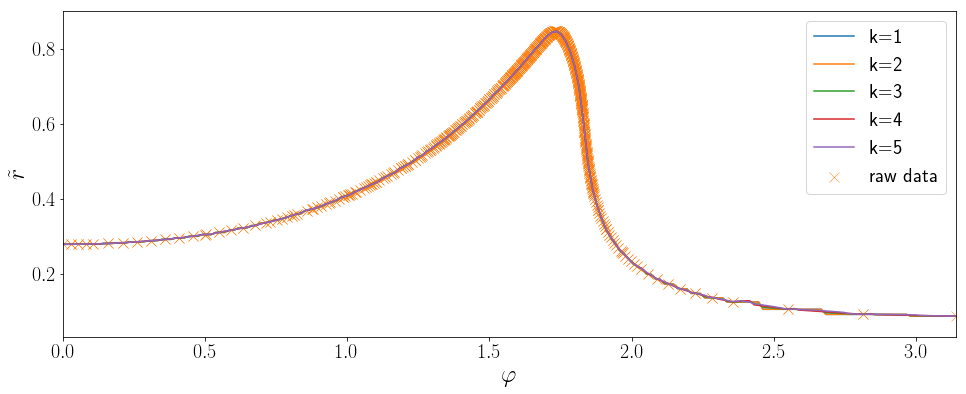

In [94]:
from sklearn import neighbors

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5, label="raw data")

for k in range(1,6):
    knn = neighbors.KNeighborsRegressor(k, weights="distance")
    rad_model = knn.fit(phi_ext[:, np.newaxis], rad_ext).predict(phi_eval[:, np.newaxis])
    ax.plot(phi_eval, rad_model, label="k={:1d}".format(k))
ax.set_xlim(0.0, np.pi)
#ax.set_ylim(0.0, 1.0)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

## Multilayer Perceptron

8.59132054668e-06 1286


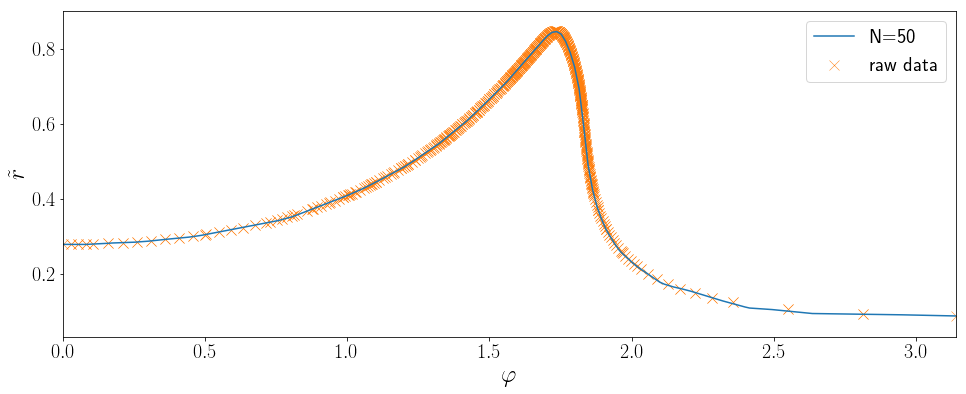

In [140]:
from sklearn.neural_network import MLPRegressor

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5, label="raw data")

mlp = MLPRegressor(hidden_layer_sizes=(50, 50, 50, 50, 50), activation="relu", max_iter=2000,
                   solver="adam", batch_size=phi_ext.shape[0], n_iter_no_change=1000, tol=1.0e-5)
rad_model = mlp.fit(phi_ext[:, np.newaxis], rad_ext).predict(phi_eval[:, np.newaxis])
print(mlp.loss_, mlp.n_iter_)
ax.plot(phi_eval, rad_model, label="N=50")

ax.set_xlim(0.0, np.pi)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)